In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

(225, 400, 3)


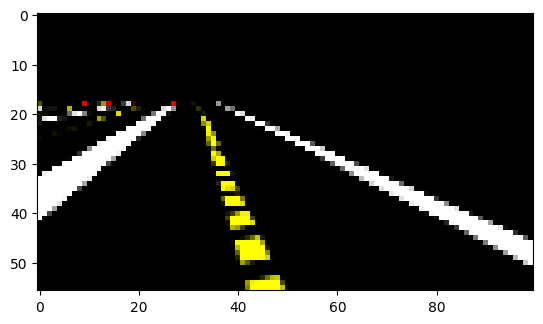

In [4]:
img = cv.imread('./sim_testing_images/straight.png')
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

print(rgb_img.shape)
tmp = cv.resize(rgb_img, (100, 56))

plt.imshow(tmp)


In [65]:
def get_yellow_blob_centers(bgr_img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # Get grayscale image with only centerline (yellow colors)
    lower_yellow = np.array([240,240,0])
    upper_yellow = np.array([255,255,0])
    centerline_gray_img = cv.inRange(rgb_img, lower_yellow, upper_yellow) # get only yellow colors in image
    
    # Get Contours for center line blobs
    contours, hierarchy = cv.findContours(centerline_gray_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    centers = []
    for i in contours:
        M = cv.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if cy > rgb_img.shape[0]//2:
                cv.drawContours(rgb_img, [i], -1, (0,255,0), 2)
                cv.circle(rgb_img, (cx, cy), 7, (0, 0, 255), -1)
                centers.append((cx, cy))
                # print(f"x: {cx}, y: {cy}")#DRAWING LINES: (order of params) --> region of interest, bin size (P, theta), min intersections needed, placeholder array, 
# lines = cv2.HoughLinesP(isolated, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
# averaged_lines = average(copy, lines)
# black_lines = display_lines(copy, averaged_lines)
# #taking wighted sum of original image and lane lines image
# lanes = cv2.addWeighted(copy, 0.8, black_lines, 1, 1)
# cv2.imshow("lanes", lanes)
# cv2.waitKey(0)

    return centers

def get_red_blob_centers(bgr_img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # Get grayscale image with only centerline (yellow colors)
    lower_red = np.array([240,0,0])
    upper_red = np.array([255,0,0])
    stopline_gray_img = cv.inRange(rgb_img, lower_red, upper_red) # get only yellow colors in image
    
    # Get Contours for center line blobs
    contours, hierarchy = cv.findContours(stopline_gray_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    centers = []
    for i in contours:
        M = cv.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if cx > rgb_img.shape[1]/4 and cx < rgb_img.shape[1]*3/4 and cy > rgb_img.shape[0]/2:
                cv.drawContours(rgb_img, [i], -1, (0,255,0), 2)
                cv.circle(rgb_img, (cx, cy), 7, (0, 0, 255), -1)
                centers.append((cx, cy))
                # print(f"x: {cx}, y: {cy}")

    return centers


In [39]:
centers = get__yellow_blob_centers(img)



[(491, 195), (404, 192), (403, 186)]


# hough transform stuff

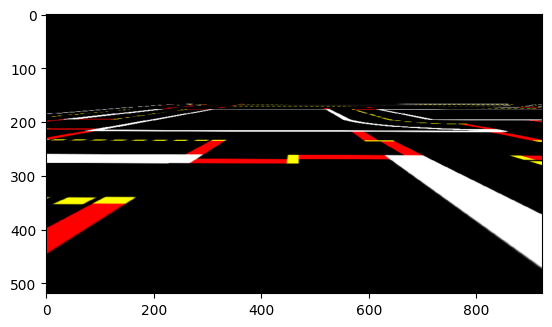

In [23]:
img = cv.imread('./sim_testing_images/intersection2.png')
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(rgb_img)

In [24]:
#https://towardsdatascience.com/deeppicar-part-4-lane-following-via-opencv-737dd9e47c96

def show_image(title, img):
    cv.imshow("img", img)
    cv.waitKey(0)
    cv.destroyAllWindows()

def detect_edges(frame):
    # filter for blue lane lines
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    # show_image("img", hsv)
    lower_white = np.array([0,0,200])
    upper_white = np.array([255,55,255])
    mask = cv.inRange(hsv, lower_white, upper_white)
    # show_image("mask", mask)

    # detect edges
    edges = cv.Canny(mask, 200, 400)
    return edges

def region_of_interest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)

    # only focus bottom half of the screen
    polygon = np.array([[
        (0, height * 1 / 2),
        (width, height * 1 / 2),
        (width, height),
        (0, height),
    ]], np.int32)

    cv.fillPoly(mask, polygon, 255)
    cropped_edges = cv.bitwise_and(edges, mask)
    return cropped_edges


In [25]:
def detect_line_segments(cropped_edges):
    # tuning min_threshold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 1  # distance precision in pixel, i.e. 1 pixel
    angle = np.radians(1)  # angular precision in radian, i.e. 1 degree
    min_threshold = 10  # minimal of votes
    line_segments = cv.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                    np.array([]), minLineLength=8, maxLineGap=4)

    return line_segments

#how to associate pixel coords to lane lines? 
# left lines should be sloped up, right should be sloped down.
# I think this is always true.... at least in bottom half of image. 



In [26]:
## NEED TO THINK ABOUT THIS PART. NEED TO TAKE DETECTED LINE SEGMENTS AND CONVERT THEM TO LEFT AND RIGHT LANE COORDS

def make_points(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        print('No line_segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1/3
    left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                print('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    print('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines

In [27]:
def detect_lane(frame):
    
    edges = detect_edges(frame)
    cropped_edges = region_of_interest(edges)
    show_image("cropped_edges", cropped_edges)
    line_segments = detect_line_segments(cropped_edges) #outputs endpoints of detected lines (x0,y0,x1,y1)
    lane_lines = average_slope_intercept(frame, line_segments)
    
    return lane_lines

In [28]:
def display_lines(frame, lines, line_color=(0, 255, 0), line_width=20):
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image

lane_lines = detect_lane(img)
lane_lines_image = display_lines(img, lane_lines)
show_image("lane lines", lane_lines_image)

lane lines: [[[-923, 519, 375, 259]], [[1066, 519, 648, 259]]]


Once lane detection works nicely, then we can probably use both the yellow blobs AND the white lines together. Ideas:

maybe find where yellow line should be based on white lines?
or use the slope of the white lines as input if it loses the yellow?


# Lane detection v2


Right Average Slope/Yint:[ 0.4155149  90.82135863]
LANES: {'right': array([1030,  519,  614,  346])}
shape: (1, 4, 2)
mask shape: (519, 923, 3)
img shape: (519, 923, 3)
Left Average Slope/Yint:[ -0.50289002 416.26930736]
LANES: {'left': array([-205,  519,  139,  346])}
shape: (1, 4, 2)
mask shape: (519, 923, 3)
img shape: (519, 923, 3)
Right Average Slope/Yint:[   0.82772143 -241.31049054]
LANES: {'right': array([918, 519, 709, 346])}
shape: (1, 4, 2)
mask shape: (519, 923, 3)
img shape: (519, 923, 3)
Right Average Slope/Yint:[   0.63388229 -152.15096254]
LANES: {'right': array([1058,  519,  785,  346])}
shape: (1, 4, 2)
mask shape: (519, 923, 3)
img shape: (519, 923, 3)
Right Average Slope/Yint:[0.47852833 4.06719508]
LANES: {'right': array([461, 225, 304, 150])}
shape: (1, 4, 2)
mask shape: (225, 400, 3)
img shape: (225, 400, 3)
Left Average Slope/Yint:[ -0.60465426 440.89007092]
Right Average Slope/Yint:[   0.61667009 -148.34198436]
LANES: {'left': array([-130,  519,  156,  346]), '

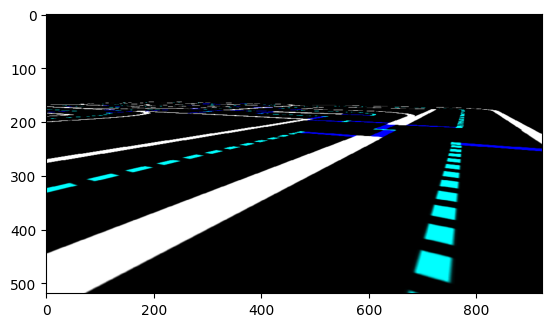

In [12]:
# -*- coding: utf-8 -*-
"""road_lane_detection.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1w6xv6v5xuQPmMJMMQ5MZnGlC6F9bsi7Q
"""

#ROAD LANE DETECTION

import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob


def grey(image):
  #convert to grayscale
    image = np.asarray(image)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  #Apply Gaussian Blur --> Reduce noise and smoothen image
def gauss(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

  #outline the strongest gradients in the image --> this is where lines in the image are
def canny(image):
    edges = cv2.Canny(image,50,150)
    return edges

def region(image):
    # only focus bottom half of the screen
    height, width = image.shape
    #isolate the gradients that correspond to the lane lines
    polygon = np.array([[
        (0, height * 2/3),
        (width, height * 2/3),
        (width, height),
        (0, height),
    ]], np.int32)

    #create a black image with the same dimensions as original image
    mask = np.zeros_like(image)
    #create a mask (triangle that isolates the region of interest in our image)
    mask = cv2.fillPoly(mask, polygon, 255)
    mask = cv2.bitwise_and(image, mask)
    return mask

def display_lines(image, lines):
    lines_image = np.zeros_like(image)
    #make sure dict isn't empty
    if lines is not None:
        for line in lines.values():
            x1, y1, x2, y2 = line
            #draw lines on a black image
            cv2.line(lines_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return lines_image

def average(image, lines):
    left = []
    right = []
    # print(f"Averaging {len(lines)} lines")
    if lines is not None:
      for line in lines:
        # print(f"\nLine (x0,y0,x1,y1): {line}")
        x1, y1, x2, y2 = line.reshape(4)
        #fit line to points, return slope and y-int
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        # print(f"slope:{parameters[0]}, y_int:{parameters[1]}")
        slope = parameters[0]
        y_int = parameters[1]
        #lines on the right have positive slope, and lines on the left have neg slope
        if slope < 0:
            left.append((slope, y_int))
            # print("Classified as left line")
        else:
            right.append((slope, y_int))
            # print("Classified as right line")

            
    #takes average among all the columns (column0: slope, column1: y_int)
    detected_lines = {}
    if len(left) > 0:
        left_avg = np.average(left, axis=0)
        print(f"Left Average Slope/Yint:{left_avg}")
        left_line = make_points(image, left_avg)
        detected_lines['left'] = left_line

    if len(right) > 0:
        right_avg = np.average(right, axis=0)
        print(f"Right Average Slope/Yint:{right_avg}")
        right_line = make_points(image, right_avg)
        detected_lines['right'] = right_line

    #create lines based on averages calculates
    return detected_lines

def make_points(image, average):
    slope, y_int = average
    y1 = image.shape[0]
    #how long we want our lines to be --> 3/5 the size of the image
    y2 = int(y1 * (2/3))
    #determine algebraically
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2])

def get_white_lane_lines(image):
    # filter for blue lane lines
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # show_image("img", hsv)
    lower_white = np.array([0,0,200])
    upper_white = np.array([255,55,255])
    mask = cv2.inRange(hsv, lower_white, upper_white)

    return mask

def detect_lanes(img):
    cv2.imshow('original frame', img)
    copy = np.copy(img)
    #threshold on white first
    white = get_white_lane_lines(copy)
    cv2.imshow('white lane lines', white)
    edges = cv2.Canny(white,50,150)
    isolated = region(edges)
    cv2.imshow("edges", edges)
    cv2.imshow("bottom third", isolated)


    #DRAWING LINES: (order of params) --> region of interest, bin size (P, theta), min intersections needed, placeholder array, 
    lines = cv2.HoughLinesP(isolated, 1, np.pi/180, 10, np.array([]), minLineLength=40, maxLineGap=5)
    # print(f"Lines found:\n {lines}")
    averaged_lines = average(copy, lines)
    # print(f"Averaged Lines:\n {averaged_lines}")
    black_lines = display_lines(copy, averaged_lines)
    #taking wighted sum of original image and lane lines image
    lanes = cv2.addWeighted(copy, 0.2, black_lines, 1, 0)
    cv2.imshow("lanes", lanes)

    return averaged_lines #dict of left or right lines as keys and values of (x0,y0,x1,y1) defining line

for filename in glob.glob('./sim_testing_images/*.png'):
    img = cv2.imread(filename)
    plt.imshow(img)
    lanes = detect_lanes(img)
    print(f"LANES: {lanes}")

    width = img.shape[1]
    height = img.shape[0]

    polygon = np.array([[
        (0, height * 2/3),
        (width, height * 2/3),
        (width, height),
        (0, height),
    ]], np.int32)
    print(f"shape: {polygon.shape}")
    # pt1 ------------- pt2
    #  |                 |
    #  |                 |
    # pt4 ------------- pt3

    for side, points in lanes.items():
        if side == "left":
            polygon[0, 0, :] = points[-2:]
            polygon[0, 3, :] = points[:2]
        elif side == "right":
            polygon[0, 1, :] = points[-2:]
            polygon[0, 2, :] = points[:2]

    #create a mask (triangle that isolates the region of interest in our image)
    mask = np.zeros(img.shape, dtype="uint8")*255
    mask = cv2.fillPoly(mask, polygon, color=(255, 255, 255))

    print(f"mask shape: {mask.shape}")
    print(f"img shape: {img.shape}")
    masked = cv2.bitwise_and(img, mask)

    # masked = cv2.addWeighted(masked, 1, img, 1, 0)
    cv2.imshow("FINAL VIEW", masked)

    cv2.waitKey(0)
    cv2.destroyAllWindows()




# PID Control 

In [5]:
from simple_pid import PID

pid = PID()
pid.Ki = -.01*0
pid.Kd = -.5*1
pid.Kp = -30/300 #degrees per pixel
pid.sample_time = 1/30.0
pid.output_limits = (-30,30)


#set point is the desired location of the blob we are trying to follow
#find blob closest to car (bottom of camera aview)
centers.sort(key = lambda x: x[1])
blobToFollowCoords = centers[-1]

#get image coords
desXCoord = rgb_img.shape[1]//2
print(f"setpoint: {desXCoord}")
pid.setpoint = desXCoord

steeringAngle = pid(blobToFollowCoords[0])
print(f"input: {blobToFollowCoords[0]}")
print(steeringAngle)


setpoint: 461
input: 368
-9.3
PID(Kp=-0.1, Ki=-0.0, Kd=-0.0, setpoint=461, sample_time=0.03333333333333333, output_limits=(-30, 30), auto_mode=True, proportional_on_measurement=False, differetial_on_measurement=True, error_map=None)


In [66]:
# PID for speed
from simple_pid import PID

red_centers = get_red_blob_centers(img)
print(red_centers)
pid = PID()
pid.Ki = -.01*0
pid.Kd = -.5*0
pid.Kp = 2/400 # speed per pixel
pid.sample_time = 1/30.0
pid.output_limits = (0.0, 2.0)

#set point is the desired location of the blob we are trying to follow
#find blob closest to car (bottom of camera aview)
if len(red_centers) != 0:
    red_centers.sort(key = lambda x: x[0])
    stopLineCoords = red_centers[-1]

    #get image coords
    desDist = rgb_img.shape[1]-100
    print(f"setpoint: {desDist}")
    pid.setpoint = desDist

    speed = pid(blobToFollowCoords[1])

    print(f"input: {blobToFollowCoords[1]}")
    print(speed)


[(303, 271)]
setpoint: 823
input: 483
1.7
